<a href="https://colab.research.google.com/github/jlavilaj/MasterER/blob/main/CuadernosJupyter/SerieTemporalPolucion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install skforecast
# Procesado de datos
# ==============================================================================
import os
import pandas as pd
import numpy as np
from skforecast.datasets import fetch_dataset

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from skforecast.plot import set_dark_theme
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff
pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)

# Keras
# ==============================================================================
os.environ["KERAS_BACKEND"] = "tensorflow" # 'tensorflow', 'jax´ or 'torch'
import keras
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.callbacks import EarlyStopping

if keras.__version__ > "3.0":
    if keras.backend.backend() == "tensorflow":
        import tensorflow
    elif keras.backend.backend() == "torch":
        import torch
    else:
        print("Backend not recognized. Please use 'tensorflow' or 'torch'.")

# Modelado
# ==============================================================================
import skforecast
from skforecast.deep_learning import ForecasterRnn
from skforecast.deep_learning.utils import create_and_compile_model
from sklearn.preprocessing import MinMaxScaler
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import backtesting_forecaster_multiseries

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('once')

color = '\033[1m\033[38;5;208m'
print(f"{color}Version skforecast: {skforecast.__version__}")
print(f"{color}Version Keras: {keras.__version__}")
print(f"{color}Using backend: {keras.backend.backend()}")
print(f"{color}Version pandas: {pd.__version__}")
print(f"{color}Version numpy: {np.__version__}")
if keras.__version__ > "3.0":
    if keras.backend.backend() == "tensorflow":
        print(f"{color}Version tensorflow: {tensorflow.__version__}")
    elif keras.backend.backend() == "torch":
        print(f"{color}Version torch: {torch.__version__}")
    else:
        print(f"{color}Version torch: {jax.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 692.3/692.3 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.9/78.9 kB 6.6 MB/s eta 0:00:00


Version skforecast: 0.14.0
Version Keras: 3.5.0
Using backend: tensorflow
Version pandas: 2.2.2
Version numpy: 1.26.4
Version tensorflow: 2.17.1


In [ ]:
# Descarga y procesado de datos
# ==============================================================================
air_quality = fetch_dataset(name="air_quality_valencia_no_missing")
air_quality.head()

air_quality_valencia_no_missing
-------------------------------
Hourly measures of several air chemical pollutant at Valencia city (Avd.
Francia) from 2019-01-01 to 20213-12-31. Including the following variables:
pm2.5 (µg/m³), CO (mg/m³), NO (µg/m³), NO2 (µg/m³), PM10 (µg/m³), NOx (µg/m³),
O3 (µg/m³), Veloc. (m/s), Direc. (degrees), SO2 (µg/m³). Missing values have
been imputed using linear interpolation.
Red de Vigilancia y Control de la Contaminación Atmosférica, 46250047-València -
Av. França, https://mediambient.gva.es/es/web/calidad-ambiental/datos-
historicos.
Shape of the dataset: (43824, 10)


so2   co    no   no2  pm10   nox    o3  veloc.  direc.  \
datetime                                                                       
2019-01-01 00:00:00   8.0  0.2   3.0  36.0  22.0  40.0  16.0     0.5   262.0   
2019-01-01 01:00:00   8.0  0.1   2.0  40.0  32.0  44.0   6.0     0.6   248.0   
2019-01-01 02:00:00   8.0  0.1  11.0  42.0  36.0  58.0   3.0     0.3   224.0   
2019-01-01 03:00:00  10.0  0.1  15.0  41.0  35.0  63.0   3.0     0.2   220.0   
2019-01-01 04:00:00  11.0  0.1  16.0  39.0  36.0  63.0   3.0     0.4   221.0   

                     pm2.5  
datetime                    
2019-01-01 00:00:00   19.0  
2019-01-01 01:00:00   26.0  
2019-01-01 02:00:00   31.0  
2019-01-01 03:00:00   30.0  
2019-01-01 04:00:00   30.0

In [ ]:
# Comprobación de índice y frecuencia
# ==============================================================================
print(f"Tipo de índice: {air_quality.index.dtype}")
print(f"Frecuencia: {air_quality.index.freq}")

Tipo de índice: datetime64[ns]
Frecuencia: <Hour>


In [ ]:
# Split train-validation-test
# ==============================================================================
air_quality = air_quality.loc[:'2021-12-31 23:00:00', :].copy()
end_train = "2021-03-31 23:59:00"
end_validation = "2021-09-30 23:59:00"
air_quality_train = air_quality.loc[:end_train, :].copy()
air_quality_val = air_quality.loc[end_train:end_validation, :].copy()
air_quality_test = air_quality.loc[end_validation:, :].copy()

print(
    f"Fechas train      : {air_quality_train.index.min()} --- "
    f"{air_quality_train.index.max()}  (n={len(air_quality_train)})"
)
print(
    f"Fechas validation : {air_quality_val.index.min()} --- "
    f"{air_quality_val.index.max()}  (n={len(air_quality_val)})"
)
print(
    f"Fechas test       : {air_quality_test.index.min()} --- "
    f"{air_quality_test.index.max()}  (n={len(air_quality_test)})"
)

Fechas train      : 2019-01-01 00:00:00 --- 2021-03-31 23:00:00  (n=19704)
Fechas validation : 2021-04-01 00:00:00 --- 2021-09-30 23:00:00  (n=4392)
Fechas test       : 2021-10-01 00:00:00 --- 2021-12-31 23:00:00  (n=2208)


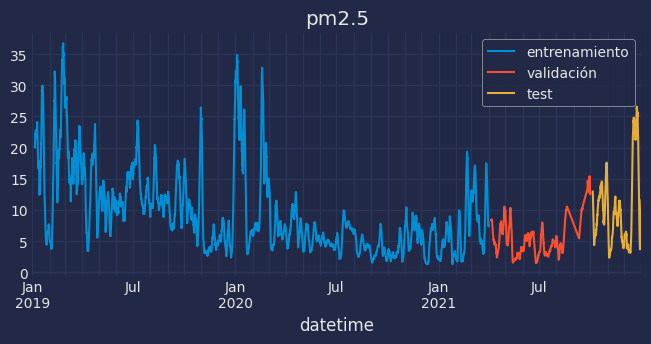

In [ ]:
# Gráfico de la serie temporal del contaminante pm2.5
# ==============================================================================
set_dark_theme()
fig, ax = plt.subplots(figsize=(7, 3))
air_quality_train["pm2.5"].rolling(100).mean().plot(ax=ax, label="entrenamiento")
air_quality_val["pm2.5"].rolling(100).mean().plot(ax=ax, label="validación")
air_quality_test["pm2.5"].rolling(100).mean().plot(ax=ax, label="test")
ax.set_title("pm2.5")
ax.legend();

In [38]:
# Creación del modelo
# ==============================================================================
series = ["no2","o3","co"]  # Series temporales que se utilizarán para entrenar el modelo.
levels = ["o3"]  # Serie que se quiere predecir
lags = 32        # Valores pasados a utilizar en la predicción
steps = 1        # Pasos a futuro a predecir

# Selección de las series temporales utilizadas
data = air_quality[series].copy()
data_train = air_quality_train[series].copy()
data_val = air_quality_val[series].copy()
data_test = air_quality_test[series].copy()

model = create_and_compile_model(
    series=data_train,
    levels=levels,
    lags=lags,
    steps=steps,
    recurrent_layer="LSTM",
    recurrent_units=4,
    dense_units=16,
    optimizer=Adam(learning_rate=0.01),
    loss=MeanSquaredError()
)
model.summary()

keras version: 3.5.0
Using backend: tensorflow
tensorflow version: 2.17.1


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 32, 3)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 4)                   │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 16)                  │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              17 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_5 (Reshape)                  │ (None, 1, 1)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 225 (900.00 B)

 Trainable params: 225 (900.00 B)

 Non-trainable params: 0 (0.00 B)

In [39]:
# Creación del forecaster
# ==============================================================================
forecaster = ForecasterRnn(
    regressor=model,
    levels=levels,
    transformer_series=MinMaxScaler(),
    fit_kwargs={
        "epochs": 10,      # Número de épocas para entrenar el modelo.
        "batch_size": 32,  # Tamaño del batch para entrenar el modelo.
        "callbacks": [
            EarlyStopping(monitor="val_loss", patience=5)
        ],  # Callback para detener el entrenamiento cuando ya no esté aprendiendo más.
        "series_val": data_val,  # Datos de validación para el entrenamiento del modelo.
    },
)
forecaster

/usr/local/lib/python3.10/dist-packages/skforecast/deep_learning/_forecaster_rnn.py:229: UserWarning:

Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.

/usr/local/lib/python3.10/dist-packages/skforecast/deep_learning/_forecaster_rnn.py:264: UserWarning:

`steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.



ForecasterRnn 
Regressor: <Functional name=functional_5, built=True> 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32] 
Transformer for series: MinMaxScaler() 
Window size: 32 
Target series, levels: ['o3'] 
Multivariate series (names): None 
Maximum steps predicted: [1] 
Training range: None 
Training index type: None 
Training index frequency: None 
Model parameters: {'name': 'functional_5', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': (None, 32, 3), 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_5'}, 'registered_name': None, 'name': 'input_layer_5', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'LSTM', 'config': {'name': 'lstm_5', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'return_sequences': False, 'return_state': False, 'go_backwards': False, '

In [40]:
# Entrenamiento del forecaster
# ==============================================================================
forecaster.fit(data_train)

Epoch 1/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.0244 - val_loss: 0.0065
Epoch 2/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.0060 - val_loss: 0.0065
Epoch 3/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.0055 - val_loss: 0.0061
Epoch 4/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0054 - val_loss: 0.0056
Epoch 5/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.0051 - val_loss: 0.0054
Epoch 6/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 0.0052 - val_loss: 0.0054
Epoch 7/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.0052 - val_loss: 0.0059
Epoch 8/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0053 - val_loss: 0.0054
Epoch 9/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.0050 - val_loss: 0.0054
Epoch 10/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.0051 - val_loss: 0.0054


In [ ]:
# Predicción
# ==============================================================================
predictions = forecaster.predict()
predictions

o3
2021-04-01  48.412697

In [21]:
# Backtesting con datos de test
# ==============================================================================
cv = TimeSeriesFold(
    steps=forecaster.max_step,
    initial_train_size=len(data.loc[:end_validation, :]), # Datos de entrenamiento + validación
    refit=False,
)
metrics, predictions = backtesting_forecaster_multiseries(
    forecaster=forecaster,
    series=data,
    levels=forecaster.levels,
    cv=cv,
    metric="mean_absolute_error",
    verbose=False,
)

<frozen importlib._bootstrap>:914: ImportWarning:

_PyDrive2ImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_PyDriveImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_GenerativeAIImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_OpenCVImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_BokehImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_AltairImportHook.find_spec() not found; falling back to find_module()



Epoch 1/10
752/752 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0052 - val_loss: 0.0056
Epoch 2/10
752/752 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0051 - val_loss: 0.0051
Epoch 3/10
752/752 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0050 - val_loss: 0.0053
Epoch 4/10
752/752 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0050 - val_loss: 0.0052
Epoch 5/10
752/752 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0051 - val_loss: 0.0054


  0%|          | 0/2208 [00:00<?, ?it/s]

In [ ]:
predictions

o3
2021-10-01 00:00:00  55.412098
2021-10-01 01:00:00  60.517220
2021-10-01 02:00:00  64.379791
2021-10-01 03:00:00  64.315826
2021-10-01 04:00:00  53.987129
...                        ...
2021-12-31 19:00:00  17.338047
2021-12-31 20:00:00  16.364244
2021-12-31 21:00:00  17.637239
2021-12-31 22:00:00  17.310850
2021-12-31 23:00:00  18.591732

[2208 rows x 1 columns]

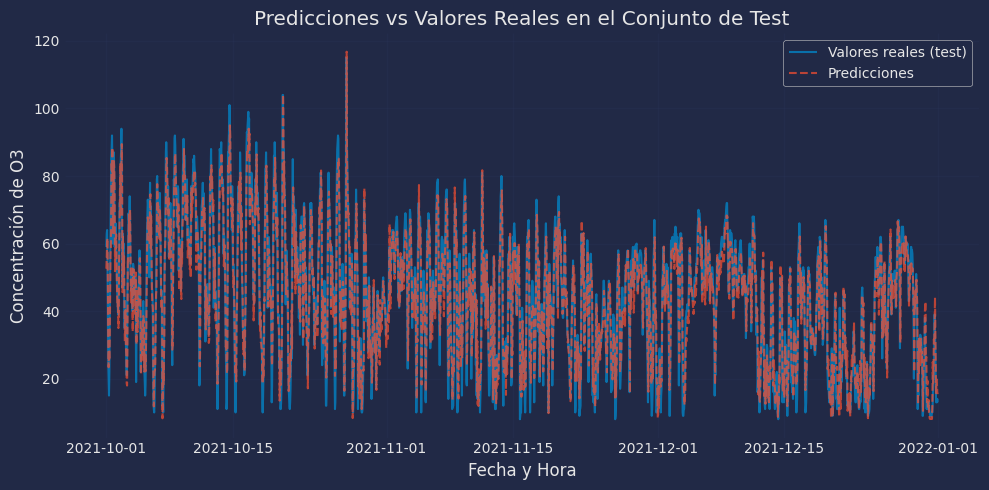

In [36]:

plt.figure(figsize=(10, 5))


plt.plot(data_test.index, data_test['o3'], label='Valores reales (test)', linestyle='-', alpha=0.7)

# Graficar las predicciones
plt.plot(predictions.index, predictions['o3'], label='Predicciones', linestyle='--', alpha=0.7)


plt.title("Predicciones vs Valores Reales en el Conjunto de Test")
plt.xlabel("Fecha y Hora")
plt.ylabel("Concentración de O3")
plt.legend()
plt.grid(alpha=0.3)


plt.tight_layout()
plt.show()

In [34]:
metrics

levels  mean_absolute_error
0     o3             6.340784

In [35]:


# Error en % respecto a la media de la serie
# ==============================================================================
rel_mse = 100 * metrics.loc[0, 'mean_absolute_error'] / np.mean(data["o3"])
print(f"Media de la serie: {np.mean(data['o3']):0.2f}")
print(f"Error (mae) relativo: {rel_mse:0.2f} %")

Media de la serie: 54.52
Error (mae) relativo: 11.63 %
